In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

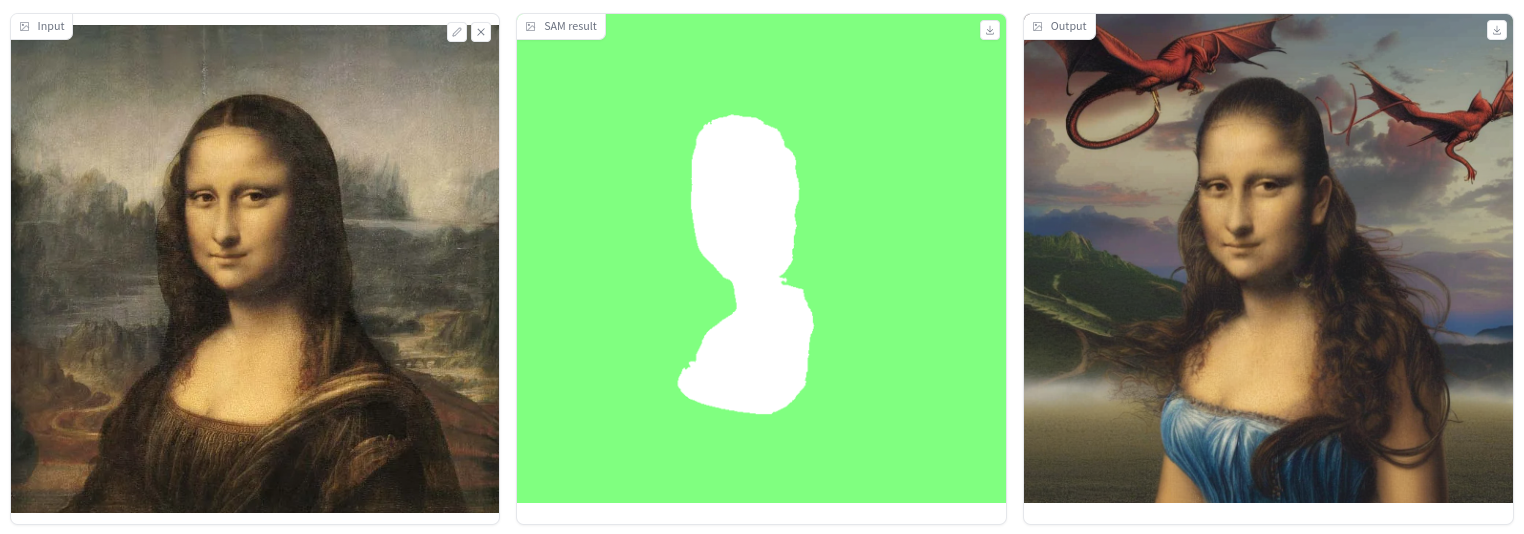

Let's start by importing what we need:

In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

import matplotlib.pyplot as plt

## SAM

Complete the following cell by loading the pretrained SAM from Facebook/Meta. Remember to:

1. Move the model to the GPU by adding `.to("cuda")`
2. Add the option `torch_dtype=torch.float16` to your call of AutoPipelineForInpainting.from_pretrained

This cell might take a couple of minutes to load.

In [2]:
# Load the SAM model as we have seen in the class
# Remeber to load it on the GPU by adding .to("cuda")
# at the end
sam_checkpoint = "facebook/sam-vit-base"
# device = "cuda" # "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained(sam_checkpoint).to(device)

# Load the SamProcessor using the facebook/sam-vit-base
# checkpoint
processor = SamProcessor.from_pretrained(sam_checkpoint)


# pipeline = AutoPipelineForInpainting.from_pretrained(
#     "runwayml/stable-diffusion-inpainting", 
#     torch_dtype=torch.float16
# ).to(device)

pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

#image = pipeline(prompt, image=init_image, mask_image=mask_image).images[0]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### Get the mask

Now that you have loaded SAM, complete the following function that uses SAM to produce a segmentation mask:

In [3]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """
    
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent

# https://huggingface.co/docs/transformers/en/model_doc/sam
def get_processed_inputs(image, input_points):
    
    # Use the processor to generate the right inputs
    # for SAM
    # Use "image" as your image
    # Use 'input_points' as your input_points,
    # and remember to use the option return_tensors='pt'
    # Also, remember to add .to("cuda") at the end
    segmentation_map = image.convert("1")
    inputs = processor(image, 
                       input_points=input_points, 
                       segmentation_maps=segmentation_map, 
                       return_tensors="pt").to(device)
    
    # Call SAM
    with torch.no_grad():
        outputs = model(**inputs)
#     outputs = # YOUR CODE HERE
    
    # Now let's post process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    # Here we select the mask with the highest score
    # as the mask we will use. You can experiment with also
    # other selection criteria, for example the largest mask
    # instead of the most confident mask
    best_mask = masks[0][0][outputs.iou_scores.argmax()] 

    # NOTE: we invert the mask by using the ~ operator because
    # so that the subject pixels will have a value of 0 and the
    # background pixels a value of 1. This will make it more convenient
    # to infill the background
    return ~best_mask.cpu().numpy()

Now let's test what we have done so far. By executing this cell you should get a visualization of the mask for the following car:

<img src='car.png' width="200px"></img>

Let's see what happens in this cell:
1. We open the image of the car and **we resize it to 512 by 512 pixels** (a square image). This makes things simpler for this project
2. We define a few points on the image that indicate where the car is
3. We use the function we have defined to generate a mask using SAM
4. We visualize the mask

The mask should look like this:

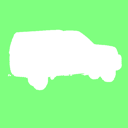

If it doesn't or you get errors, double check the code you have completed above and fix it before moving on.

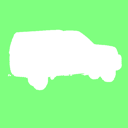

In [4]:
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

mask = get_processed_inputs(raw_image, input_points)

Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

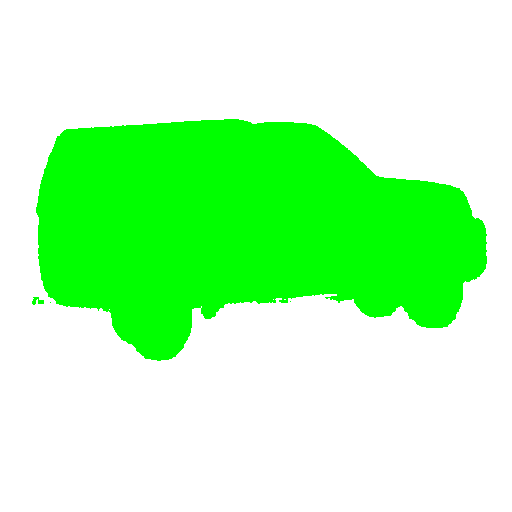

In [5]:
mask_bool = mask.astype(bool)

# Make sure image and mask are the same size
raw_image = raw_image.resize((mask_bool.shape[1], mask_bool.shape[0]))

# Define colors
white = np.array([255, 255, 255], dtype=np.uint8)  # subject color
green = np.array([0, 255, 0], dtype=np.uint8)      # background color

# Apply colors: where mask == True → white, else green
vis = np.where(mask_bool[..., None], white, green)

# Convert to PIL Image and display inline
Image.fromarray(vis)

## Inpainting

Now that we have completed the SAM setup, let's move to the inpainting setup.

Let's start by loading our inpainting pipeline. We will use the `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` pretrained model and the `AutoPipelineForInpainting` as we have seen in our `diffusers` demo in Lesson 5.

Complete the following code and run it (it might take a few minutes to run):

> **NOTE**: you will probably see a warning similar to ``The config attributes {'decay'...``. Please ignore it. It is a warning generated by the diffusers library that does not constitute a problem for our application

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = AutoPipelineForInpainting.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
pipeline.enable_attention_slicing()

# This will make it more efficient on our hardware
# pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt: 0.00B [00:00, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/vocab.json: 0.00B [00:00, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Now complete the following function that gets in input:
1. The raw image
2. The mask generated by SAM (a numpy array)
3. The text prompt for the infill
4. An optional negative prompt
5. An optional seed for repeatibility
6. The Classifier-Free Guidance Scale (CFGS). If you don't remember what this is, refer to the Text Conditioning explanation in Lesson 5

In [7]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
        
    # subject_mask: bool array (True = car)
    background_mask = ~input_mask                       # replace background
    mask_255 = (background_mask.astype(np.uint8) * 255)   # 0/255
    mask_pil = Image.fromarray(mask_255, mode="L")

    # Ensure same size as the input image
    img_pil = raw_image.resize(mask_pil.size)
    
    
    #####################
    steps = 30
    generator = torch.Generator(device).manual_seed(seed)

    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=img_pil,
        mask_image=mask_pil,
        guidance_scale=cfg,
        num_inference_steps=steps,
        generator=generator
    ).images[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_pil); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow((input_mask * 255).astype(np.uint8), cmap="gray"); ax[1].set_title("Mask (Car)"); ax[1].axis("off")
    ax[2].imshow(image); ax[2].set_title("Mars Background"); ax[2].axis("off")
    plt.tight_layout(); plt.show()    
    
    
    
    return image

# image = pipeline(prompt, image=init_image, mask_image=mask_image).images[0]

Let's test our inpainting on the mask we have obtained earlier with SAM:

  0%|          | 0/30 [00:00<?, ?it/s]

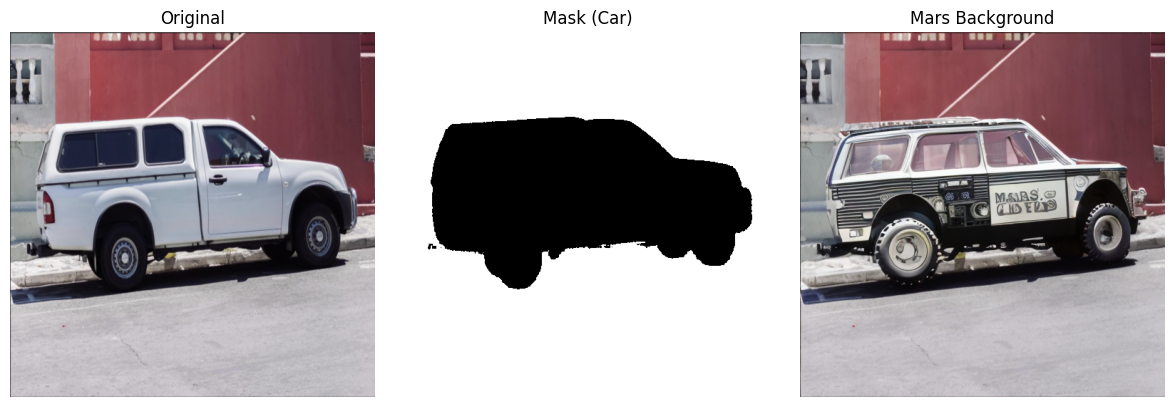

In [8]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

cfg = 7.0
steps = 30
# generator = torch.Generator(device).manual_seed(74294536)


image = inpaint(raw_image, mask, prompt, negative_prompt)

Let's have a look at what we have produced:

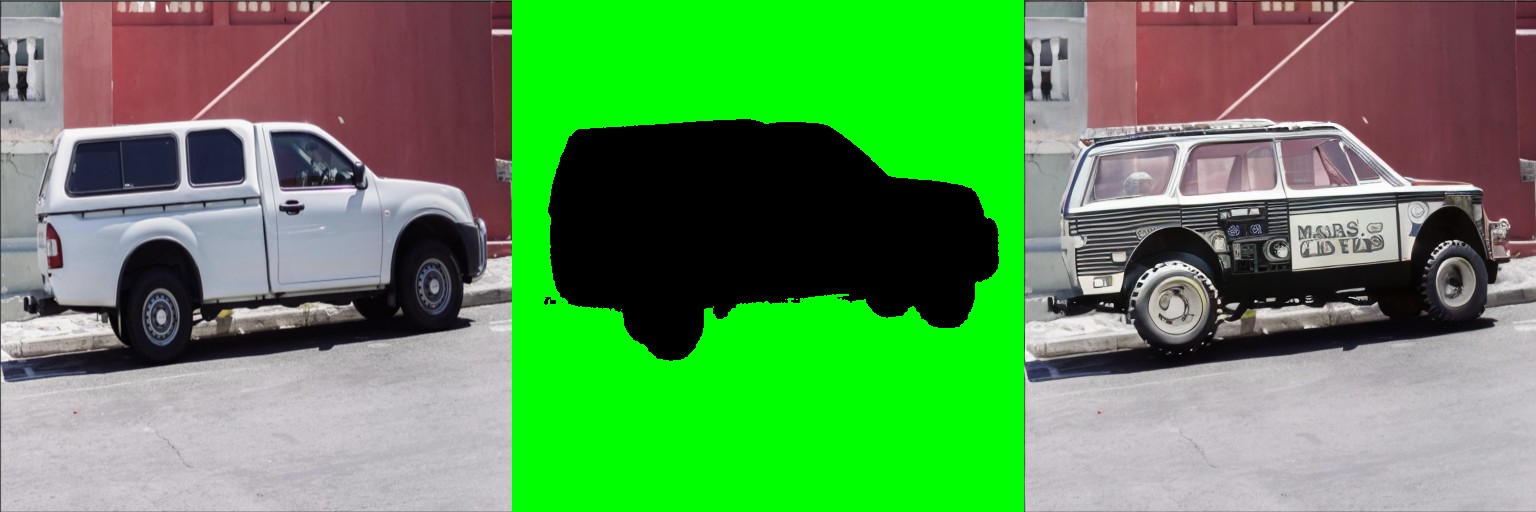

In [9]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:

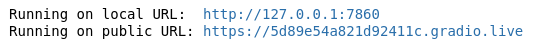

Click on the second link (the public URL), from there you will be able to use the app much more comfortably.

> NOTE: if for any reason you need to stop the app, click on the stop icon of the jupyter interface:   then **execute the next cell containing the code `my_app.close`**


In [10]:
import app

In [ ]:
my_app = app.generate_app(get_processed_inputs, inpaint)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://78d3a1d59560ab4c41.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
my_app.close()